# Part IV -  ML For Interpersonal Physical Alignment
#####  @ Haim Goldfisher

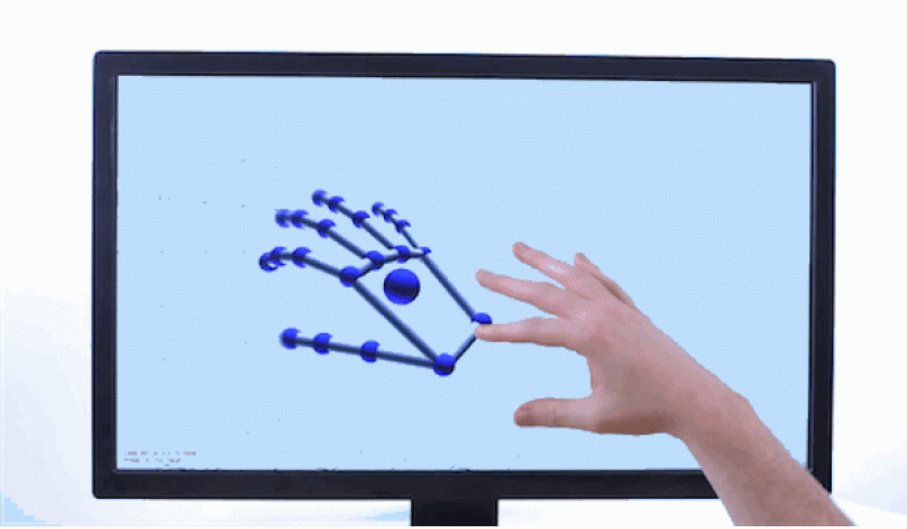

# Libraries Importation:

In [1]:
import cv2 # openCv
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Brief Summary:

The purpose of the work is to classify between three different situations in the way people communicate with each other:
- The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other.
- The second is a synchronous movement in which the two people move their hands together. 
- The third is a movement in position own (alone). Where only one side moves the hands.

The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous.

The experiment is based on synchronization between two people. That is, they both "transmit on the same wave" so that no one is leading this synchronization. In this case the argument is that there is not one "brain" of the two that leads but two brains of two people uniting into a spring of cooperation that is supposedly above both of them, which controls their movements in the synchronization process.

The experiment uses a system that captures the position of a person's hands. The system knows where the hand is. The experiment places two people facing each other. The experiment operation tells them to move their hands in front of each other spontaneously. He then asks them to be in sync (the process causes both parties to try to be in sync). People begin to perceive each other in order to understand the other side (there must be no imitation of one side, otherwise it does not work). We have three situations: alone, spontaneous in front of another person and in sync with another person.

Assumption of the experiment: The felt state will necessarily be different from the spontaneous state. That is, an experience of looking at another person, the connection between them automatically changes the movement of the two people (as long as they do not have autism). Also, the distance between the two people should be taken into account, because a person alone will move freely when there is no person next to him that he can hurt. In contrast, people who stand relatively close will inevitably move in more measured movements so as not to accidentally hurt each other.

Note, the literature defines synchronization as a product of a velocity vector. When people are in sync, they have the same velocity vector. The above experiment examines the definition of synchronization as the location of the two entities to each other at a given time.

# A Little Bit About The Data:

##### Documentation: https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html

First of all, let's note that this is a classification problem with three labels: alone, spontaneous and synchronized.

Each CSV file belongs to one of the three labels, and is associated with one of the people who performed the experiment. The data frame of each experiment contains 22 features:

1. Time -
2. Frame ID -
3. Hand Type (right/left) -
4. number hands (1/2) -
5. ,6,7.  Position X,Y,Z -
8. ,9,10. Velocity X,Y,Z -
11. Pitch -
12. Roll -
13. Yaw -
14. ,15,16. Wrist Pos X,Y,Z -
17. ,18,19. Elbow pos X,Y,Z -
20. Grab Strenth -
21. Grab Angle -
22. Pinch Strength -

The task: to take the data, arrange it using PANDAS, and then produce an optimal model that given the hand position, we can identify in which one of the three possibilities the person was: alone, spontaneous and synchronized.

# Strategy:

We would like to work with TimeSeries to classify the variance during the time. Moreover, we know that 

Work only with training data. Do not touch on validation during model preparation but only at the prediction stage.
We have in the experiment 9 people who each have data depending on the people they were in front of (maybe there is a difference between the people who were in front of them or their order).
If both hands do not appear at the same time - not correct. (Should be both right and left for all time \ ID ie time \ ID must appear twice, otherwise it must be removed).
Usually a second recording is better because the person has already gotten used to the state of the experiment.
Please note, TRAINING is the first 40 seconds, TESTING is the last 20 seconds. This is obligatory from reality because there is a clear correlation between what happened before the moment and what will happen or happened a moment before or after. That is, the position of the hand in one frame and in the frame after it will always be very close.
It is recommended to take a maximum of 4 frames per second (if you want to get rid of a certain part of the data, you can for example take two samples from the data every second, assuming it does not go so far during the second - if the download does not hurt the model, but no more than 4 frames per second).
Recommended way of working - build a model for one person. Then try it on another person and then fix so that the model "catches" the two people and so on.
The conclusion of the experiment: The position vector exceeds the velocity vector. Synchronization is expressed in the need of the two people to find synchronization at the level of their location opposite each other, and not the same speed of movement.

# Datasets & Data Preprocessing:

Following the instructions, I filtered the CSV files before loading them. That is, I removed the unnecessary files so that in each folder only the three relevant files (the last three) would appear. Also, depending on what was required, the first 7 seconds were removed from each CSV file (using pandas method).

In [320]:
# inner fuction to add HandRight to 'Alone's files

def alone_handright(dataframe):
    
    df = dataframe.copy()
    df = df[df[' Hand Type']=='left'] # drop right from alone
    df.reset_index(drop=True, inplace=True)
    right = pd.read_csv(r'C:\Haim\Anaconda\Experiment\HandRight.csv')
    right = (right[right["Time"] > (right["Time"][0]+7)]) # the 7 first second are being removed
    right.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) # drop rows with null values
    min_len = min(len(right), len(df))
    df, right = df[:min_len], right[:min_len]
    right.drop(['Time', ' Frame ID'], axis=1, inplace=True)
    right['Time'] = list(df['Time'])
    right[' Frame ID'] = list(df[' Frame ID'])
    df = pd.concat([right, df], axis=0).sort_index()
    
    return df

In [321]:
# inner function to perform the required changes on the data

def pandas_preprocessing(dataframe):
    df = dataframe.copy()
    left = df.loc[df[' Hand Type']=='left']
    right = df.loc[df[' Hand Type']=='right']
    df = pd.merge(left, right, how='outer', on=['Time', ' Frame ID', ' # hands'])
    df.drop([' Hand Type_x', ' Hand Type_y', ' # hands'], axis=1, inplace=True)
    df.dropna(axis = 0, inplace=True, how="any") # for left which has no right or the opposite

    # SAMPELS CREATION:
    
    df = df[df.index % 15 == 0]
    
    return df
    

In [322]:
def upload(path):
    folders = glob.glob(path + "/*") # the folder of all folders
    data = [] # output
    labels = ["Alone", "Spontan", "Sync"] # all options
    for folder_name in folders: # run over the folders
        files = glob.glob(folder_name + "/*.csv") # the csv files
        for filename in files: # run over each csv in the folder
            df = pd.read_csv(filename, index_col=None, header=0) # read the currect csv file
            df = (df[df["Time"] > (df["Time"][0]+7)]) # the 7 first second are being removed
            for label in labels: # it checks which one of the 3 labels this csv is
                if label in filename: # for adding the correct label to the correct df
                    if label == 'Alone': # unique function for alone???
                        df = alone_handright(df) # add hand right to the csv
                    if "Train"  in folder_name: # for Train upload:
                        experimenter = folder_name.split('g')[1][1:] # for train df
                    else: # for Test upload:
                        experimenter = folder_name.split('n')[4][1:] # for validation df
                    df = pandas_preprocessing(df)
                    df["Label"] = label # new feature with the label name
                    df["Name"] = experimenter # new feature with the experimenter name                     
            data.append(df)
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [323]:
path = "C:\Haim\Anaconda\Experiment\Training"
df_train = upload(path)

In [324]:
df_train

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
0      71.41422      98073     -109.80610       228.3820      87.325780   
1      71.74539      98111     -122.37270       278.2248      70.006340   
2      72.07722      98149     -120.25160       237.1003     103.862700   
3      72.40811      98187     -124.62430       292.1527      45.714020   
4      72.73940      98225     -110.35740       224.4479      18.870340   
...         ...        ...            ...            ...            ...   
8698  853.06500      67100      -66.35506       169.2483     -19.477700   
8699  853.72940      67142      -61.89313       133.6728     -26.208020   
8700  854.39640      67186      -72.26691       191.7859      -5.365688   
8701  855.06320      67230      -78.38692       201.1568      -1.038956   
8702  855.72960      67276      -67.31480       141.4773     -28.841140   

       Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x    Roll_x  ...  \
0        -41.538020     116.707100     -60.097880  2.147859  0.867143  ...   
1        -47.986310      27.119870     165.227500  1.780755  1.092412  ...   
2        -27.606670     153.094500     -95.064770  2.184623  0.915921  ...   
3        -54.225250      33.210850    -207.112500  1.710385  1.077068  ...   
4         78.684850    -167.798800      -9.469780  1.306937  0.607577  ...   
...             ...            ...            ...       ...       ...  ...   
8698      82.465680     -77.528030      -3.683113  0.852544  1.665028  ...   
8699      18.286170      -2.369526     -26.218050  0.068824  2.218081  ...   
8700      26.017800     103.758700      -9.151154  0.949918  1.474985  ...   
8701      -8.298981     -22.080000      -7.139415  1.091639  1.492869  ...   
8702     -14.888220       7.543926     -16.640030  0.052639  2.266229  ...   

       Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y   Elbow Pos Y_y  \
0           166.6150        15.43945        313.4828        3.741617   
1           197.3970        73.94775        339.7226        3.908131   
2           199.6836        73.00286        330.5596      -11.418840   
3           175.5724        34.17116        299.7994      -16.157260   
4           146.3091        12.55164        340.3484       80.271090   
...              ...             ...             ...             ...   
8698        130.5990        46.11774        273.3562      -70.154910   
8699        137.3681        53.16009        326.1196       22.928660   
8700        145.0588        53.81126        290.8133      -54.521160   
8701        137.3200        54.73908        312.9934      -39.512720   
8702        150.8263        57.90788        341.6186       52.031950   

       Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y   Pinch Strength_y  \
0          144.85630         0.000000       0.229723                0.0   
1          118.98970         0.000000       0.475456                0.0   
2          108.71200         0.000000       0.405120                0.0   
3          154.29330         0.332654       1.475574                0.0   
4          197.71170         1.000000       3.141593                1.0   
...              ...              ...            ...                ...   
8698       103.55590         0.000000       0.000000                0.0   
8699       166.21070         0.000000       0.000000                0.0   
8700        87.34460         0.000000       0.000000                0.0   
8701        43.16436         0.000000       0.000000                0.0   
8702       171.60720         0.000000       0.000000                0.0   

        Label           Name  
0     Spontan  Evyatar Cohen  
1     Spontan  Evyatar Cohen  
2     Spontan  Evyatar Cohen  
3     Spontan  Evyatar Cohen  
4     Spontan  Evyatar Cohen  
...       ...            ...  
8698     Sync       Yoel Raz  
8699     Sync       Yoel Raz  
8700     Sync       Yoel Raz  
8701     Sync       Yoel Raz  
8702     Sync       Yoel Raz  

[8703 rows x 40 columns]

In [327]:
df_train.shape

(8703, 40)

In [328]:
df_train.groupby('Label').count()

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
Label                                                                   
Alone    2673       2673           2673           2673           2673   
Spontan  3036       3036           3036           3036           3036   
Sync     2994       2994           2994           2994           2994   

          Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x   Roll_x  ...  \
Label                                                                    ...   
Alone             2673           2673           2673      2673     2673  ...   
Spontan           3036           3036           3036      3036     3036  ...   
Sync              2994           2994           2994      2994     2994  ...   

          Wrist Pos X_y   Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y  \
Label                                                                     
Alone              2673            2673            2673            2673   
Spontan            3036            3036            3036            3036   
Sync               2994            2994            2994            2994   

          Elbow Pos Y_y   Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y  \
Label                                                                     
Alone              2673            2673             2673           2673   
Spontan            3036            3036             3036           3036   
Sync               2994            2994             2994           2994   

          Pinch Strength_y  Name  
Label                             
Alone                 2673  2673  
Spontan               3036  3036  
Sync                  2994  2994  

[3 rows x 39 columns]

In [329]:
df_train.groupby('Name').count()

Time   Frame ID   Position X_x   Position Y_x  \
Name                                                                 
Evyatar Cohen        1215       1215           1215           1215   
Nofar Social_Nuero   1206       1206           1206           1206   
Oriya Social_Nuero   1391       1391           1391           1391   
Orya Kalmanovitz      992        992            992            992   
Revital Marbel        956        956            956            956   
Shahar Terner         606        606            606            606   
Shelly Social_Nuero  1172       1172           1172           1172   
Yael Ha               578        578            578            578   
Yoel Raz              587        587            587            587   

                      Position Z_x   Velocity X_x   Velocity Y_x  \
Name                                                               
Evyatar Cohen                 1215           1215           1215   
Nofar Social_Nuero            1206           1206           1206   
Oriya Social_Nuero            1391           1391           1391   
Orya Kalmanovitz               992            992            992   
Revital Marbel                 956            956            956   
Shahar Terner                  606            606            606   
Shelly Social_Nuero           1172           1172           1172   
Yael Ha                        578            578            578   
Yoel Raz                       587            587            587   

                      Velocity Z_x   Pitch_x   Roll_x  ...   Wrist Pos X_y  \
Name                                                   ...                   
Evyatar Cohen                 1215      1215     1215  ...            1215   
Nofar Social_Nuero            1206      1206     1206  ...            1206   
Oriya Social_Nuero            1391      1391     1391  ...            1391   
Orya Kalmanovitz               992       992      992  ...             992   
Revital Marbel                 956       956      956  ...             956   
Shahar Terner                  606       606      606  ...             606   
Shelly Social_Nuero           1172      1172     1172  ...            1172   
Yael Ha                        578       578      578  ...             578   
Yoel Raz                       587       587      587  ...             587   

                      Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y  \
Name                                                                  
Evyatar Cohen                  1215            1215            1215   
Nofar Social_Nuero             1206            1206            1206   
Oriya Social_Nuero             1391            1391            1391   
Orya Kalmanovitz                992             992             992   
Revital Marbel                  956             956             956   
Shahar Terner                   606             606             606   
Shelly Social_Nuero            1172            1172            1172   
Yael Ha                         578             578             578   
Yoel Raz                        587             587             587   

                      Elbow Pos Y_y   Elbow Pos Z_y   Grab Strenth_y  \
Name                                                                   
Evyatar Cohen                  1215            1215             1215   
Nofar Social_Nuero             1206            1206             1206   
Oriya Social_Nuero             1391            1391             1391   
Orya Kalmanovitz                992             992              992   
Revital Marbel                  956             956              956   
Shahar Terner                   606             606              606   
Shelly Social_Nuero            1172            1172             1172   
Yael Ha                         578             578              578   
Yoel Raz                        587             587              587   

                      Grab Angle_y   Pinch Strength_y  Label  
Name

In [330]:
path = "C:\Haim\Anaconda\Experiment\Validation"
df_test = upload(path)

In [331]:
df_test.head()

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
0  452.3260      53462      -118.2152       174.2778      12.799050   
1  452.6573      53500      -123.1043       178.8127      11.700790   
2  452.9886      53539      -120.6839       176.9919       7.633155   
3  453.3200      53577      -124.2295       188.5083      15.562180   
4  453.6518      53615      -118.1776       164.8339       8.295920   

    Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x    Roll_x  ...  \
0      37.165200       22.34652      -4.754824  0.324394  0.238341  ...   
1       5.793713      -50.34099      10.795690  0.574810  0.521257  ...   
2     -53.201230       88.61603     -15.302580  0.477401  0.429291  ...   
3      18.063140      -72.58926     -18.754490  0.831376  0.654066  ...   
4      52.861140      101.60810     -52.115040 -0.021758  0.375435  ...   

    Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y   Elbow Pos Y_y  \
0        117.8634        35.15458        345.4367        -2.93104   
1        161.8418        63.71194        375.0383        33.85086   
2        227.3930        60.66499        354.5391        63.70380   
3        129.5563        36.54151        357.2130        17.31680   
4        149.9179        35.34182        345.2206        95.39789   

    Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y   Pinch Strength_y    Label  \
0       148.57010              0.0       0.330704                0.0  Spontan   
1       141.80330              0.0       0.894335                0.0  Spontan   
2        81.25557              0.0       0.927244                0.0  Spontan   
3       182.90530              0.0       0.676991                0.0  Spontan   
4       227.97650              0.0       0.664747                0.0  Spontan   

        Name  
0  Itiel Lab  
1  Itiel Lab  
2  Itiel Lab  
3  Itiel Lab  
4  Itiel Lab  

[5 rows x 40 columns]

# Explore The Data:

In [270]:
df_train.isna().sum().sum()

0

In [332]:
# we will map our labels & Names into numbers:

mapping = {'Alone':0, 'Spontan':1, 'Sync':2}
df_train.Label = df_train.Label.map(mapping)
df_train.sample(3, random_state=555)

Time   Frame ID   Position X_x   Position Y_x   Position Z_x  \
3572  675.01670      77875     -110.95310       150.4004       11.05246   
5891  430.13060      52143      -96.88735       148.0362      -32.45509   
2440   65.30943       7599     -156.60600       173.6945       41.04749   

       Velocity X_x   Velocity Y_x   Velocity Z_x   Pitch_x    Roll_x  ...  \
3572     -271.42790     126.856700      -15.25997 -1.501179 -0.097308  ...   
5891      -45.69493       5.057594      -26.93568  0.182727  2.638707  ...   
2440     -132.14970      51.452230       14.89285  1.013647  3.096288  ...   

       Wrist Pos Y_y   Wrist Pos Z_y   Elbow pos X_y   Elbow Pos Y_y  \
3572        145.4188        90.00842        137.7551        29.79210   
5891        178.7656        30.12268        332.8759       -23.30339   
2440        184.4769       137.56010        395.7863       109.98820   

       Elbow Pos Z_y   Grab Strenth_y   Grab Angle_y   Pinch Strength_y  \
3572       252.70530              0.0       0.360361                0.0   
5891        95.79373              0.0       0.000000                0.0   
2440       234.50720              0.0       0.146170                0.0   

      Label                Name  
3572      0  Oriya Social_Nuero  
5891      1       Shahar Terner  
2440      1  Oriya Social_Nuero  

[3 rows x 40 columns]

In [333]:
# A function to show the labels
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Alone',
    1 :'Spontan',
    2 :'Sync'}
    labeled = label.map(mapping)
    return labeled

In [334]:
target = df_train['Label'] # the feature we would like to predict, the label of picture
data = df_train.drop(['Label',' Frame ID','Name','Time'], axis = 1) # we will drop y from x, because we want to predict it

In [336]:
fig = px.scatter_3d(data, x=' Position X_x', y=' Position Y_x', z=' Position Z_x',
              color=num_to_name(target))
fig.show()

# Train / Test Split:

In [337]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=18)


# Scaling:

In [10]:
scaler = StandardScaler()

# Dimensionality Reduction:

In [338]:
pca = PCA()
pca.fit(X_train)

PCA()

In [340]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    title = "Explained variance as a function of the number of dimensions:",
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul * 100,
    labels={"x": "# of features", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)

In [341]:
pca = PCA(n_components=0.95) # we can try using svd_solver="randomized"
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

12

In [342]:
# A three-dimensional graph depicting the way our data is interpreted, plotly does it easily for us 
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    X_train_reduced, x=0, y=1, z=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [343]:
# 2D version: with x and y

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [344]:
# 2D version: with y and z

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [345]:
# 2D version: with z and y

total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

In [346]:
X_train = pd.DataFrame(X_train_reduced)
X_val = pd.DataFrame(X_val_reduced)

# Models

## Naive Bayes:

In [347]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes

GaussianNB()

In [348]:
y_pred = bayes.predict(X_val)
bayes_acc = accuracy_score(y_val, y_pred)
bayes_acc

0.7800114876507754

In [349]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       551
           1       0.69      0.66      0.68       584
           2       0.68      0.70      0.69       606

    accuracy                           0.78      1741
   macro avg       0.78      0.79      0.78      1741
weighted avg       0.78      0.78      0.78      1741



## KNN:

In [350]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn

KNeighborsClassifier()

In [351]:
y_pred = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred)
knn_acc

0.8334290637564618

In [352]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       551
           1       0.76      0.75      0.76       584
           2       0.76      0.77      0.76       606

    accuracy                           0.83      1741
   macro avg       0.84      0.84      0.84      1741
weighted avg       0.83      0.83      0.83      1741



## Logistic Regression:

In [353]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr

LogisticRegression()

In [354]:
y_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val, y_pred)
lr_acc

0.7581849511774842

In [355]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       551
           1       0.64      0.68      0.66       584
           2       0.67      0.61      0.64       606

    accuracy                           0.76      1741
   macro avg       0.76      0.76      0.76      1741
weighted avg       0.76      0.76      0.76      1741



## CatBoost:

In [356]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train, y_train)
cat

In [357]:
y_pred = cat.predict(X_val)
y_pred_cat = y_pred.copy()
cat_acc = accuracy_score(y_val, y_pred)
cat_acc

0.8707639287765652

In [358]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       551
           1       0.80      0.84      0.82       584
           2       0.83      0.79      0.81       606

    accuracy                           0.87      1741
   macro avg       0.87      0.87      0.87      1741
weighted avg       0.87      0.87      0.87      1741



## AdaBoost:

In [359]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada

AdaBoostClassifier()

In [360]:
y_pred = ada.predict(X_val)
ada_acc = accuracy_score(y_val, y_pred)
ada_acc

0.7363584147041929

In [361]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       551
           1       0.58      0.82      0.68       584
           2       0.70      0.42      0.53       606

    accuracy                           0.74      1741
   macro avg       0.76      0.75      0.73      1741
weighted avg       0.75      0.74      0.73      1741



## Gradient Boosting:

In [362]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb

GradientBoostingClassifier()

In [363]:
y_pred = gb.predict(X_val)
gb_acc = accuracy_score(y_val, y_pred)
gb_acc

0.829408385985066

In [364]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       551
           1       0.73      0.81      0.77       584
           2       0.79      0.70      0.74       606

    accuracy                           0.83      1741
   macro avg       0.83      0.83      0.83      1741
weighted avg       0.83      0.83      0.83      1741



## XGBoosting:

In [365]:
xgb = XGBClassifier(use_label_encoder =False)
xgb.fit(X_train, y_train)
xgb

[20:31:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [366]:
y_pred = xgb.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred)
xgb_acc

0.8604250430786904

In [367]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       551
           1       0.78      0.82      0.80       584
           2       0.82      0.77      0.79       606

    accuracy                           0.86      1741
   macro avg       0.86      0.86      0.86      1741
weighted avg       0.86      0.86      0.86      1741



## Random Forest:

In [368]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf

RandomForestClassifier()

In [369]:
y_pred = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc

0.8575531303848363

In [370]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       551
           1       0.77      0.84      0.80       584
           2       0.83      0.75      0.79       606

    accuracy                           0.86      1741
   macro avg       0.86      0.86      0.86      1741
weighted avg       0.86      0.86      0.86      1741



In [372]:
stacking = StackingClassifier(estimators=[('gxb',xgb),('cat',cat)],final_estimator=cat)
stacking.fit(X_train,y_train)
stacking

[20:33:27] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:36] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:37] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:33:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

StackingClassifier(estimators=[('gxb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=8,
                                              num_parallel_tree=1,
                                              objective='multi:softprob',
 

In [373]:
y_pred = stacking.predict(X_val)
stacking_acc = accuracy_score(y_val, y_pred)
stacking_acc

0.8558299827685238

In [374]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       551
           1       0.77      0.82      0.80       584
           2       0.81      0.76      0.79       606

    accuracy                           0.86      1741
   macro avg       0.86      0.86      0.86      1741
weighted avg       0.86      0.86      0.86      1741



## Voting:

### Soft Voiting:

In [375]:
sv = VotingClassifier(estimators=[
        ('xgb', xgb), ('cat', cat)], voting='soft') # , ('rf', clf3)
sv.fit(X_train, y_train)
sv

[20:35:01] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                             

In [376]:
y_pred = sv.predict(X_val)
sv_acc = accuracy_score(y_val, y_pred)
sv_acc

0.8684663986214819

In [377]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       551
           1       0.80      0.84      0.82       584
           2       0.83      0.78      0.81       606

    accuracy                           0.87      1741
   macro avg       0.87      0.87      0.87      1741
weighted avg       0.87      0.87      0.87      1741



### Hard Voting:

In [381]:
hv = VotingClassifier(estimators=[
        ('xgb', xgb), ('cat', cat)], voting='hard') # , ('rf', clf3)
hv.fit(X_train, y_train)
hv

[20:37:35] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                             

In [382]:
y_pred = hv.predict(X_val)
hv_acc = accuracy_score(y_val, y_pred)
hv_acc

ValueError: could not broadcast input array from shape (1741,1) into shape (1741)

In [ ]:
print (classification_report(y_val, y_pred))

# Cross Validation

# Conclusion

# Test